
Running experiment for K=1...
Confusion Matrix:
[[681.   5.   2.]
 [  0. 742.   5.]
 [  2.  19. 629.]]
Accuracy: 0.9842
Precision: 0.9849
Recall: 0.9836
F1-Score: 0.9842


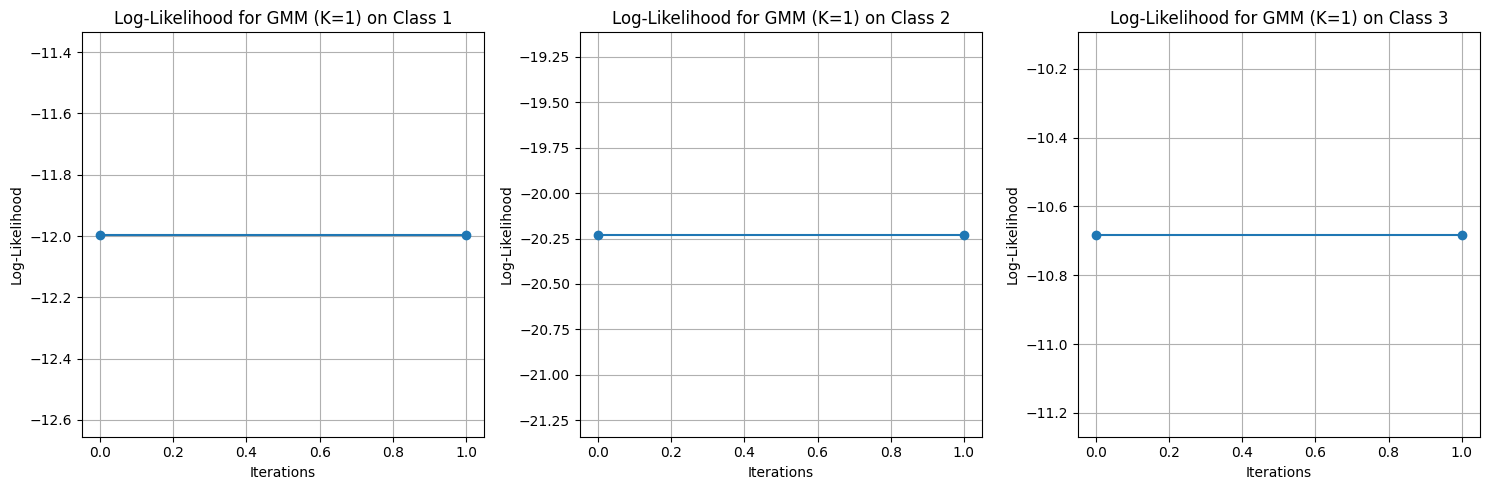

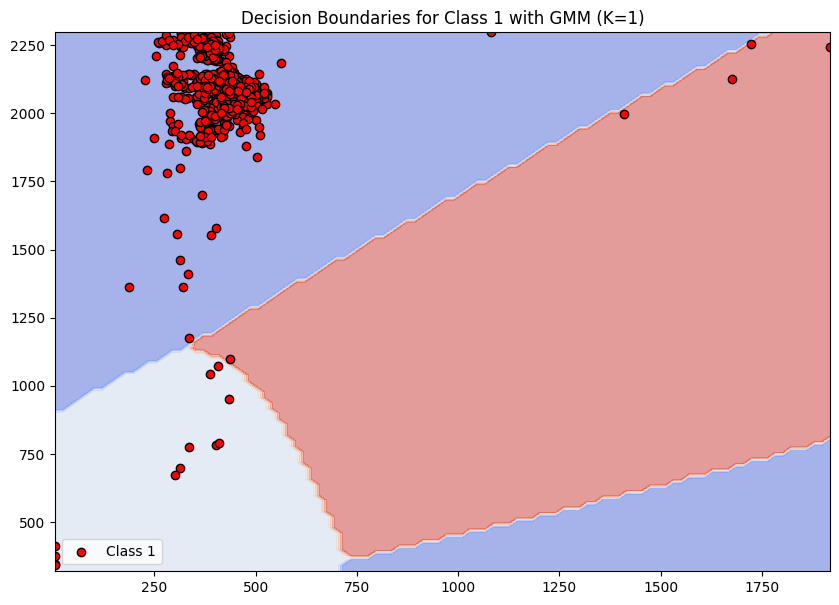

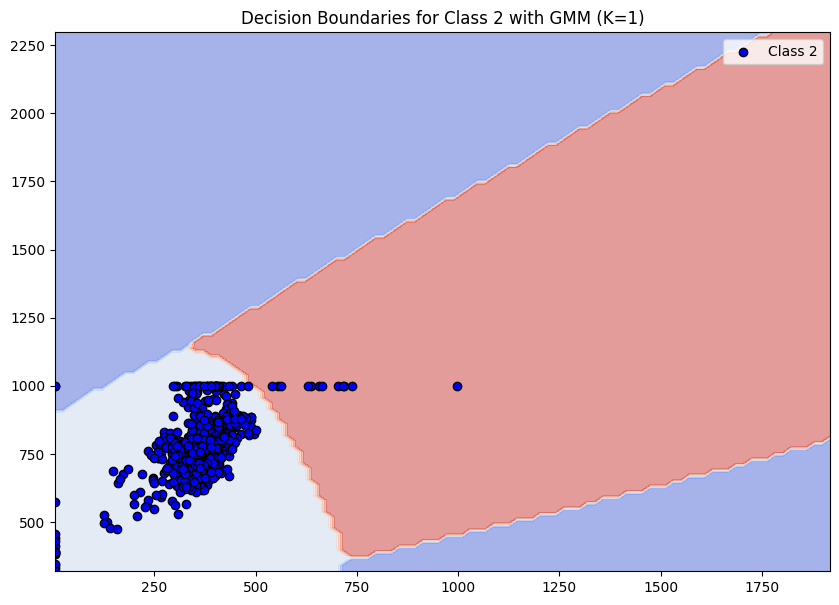

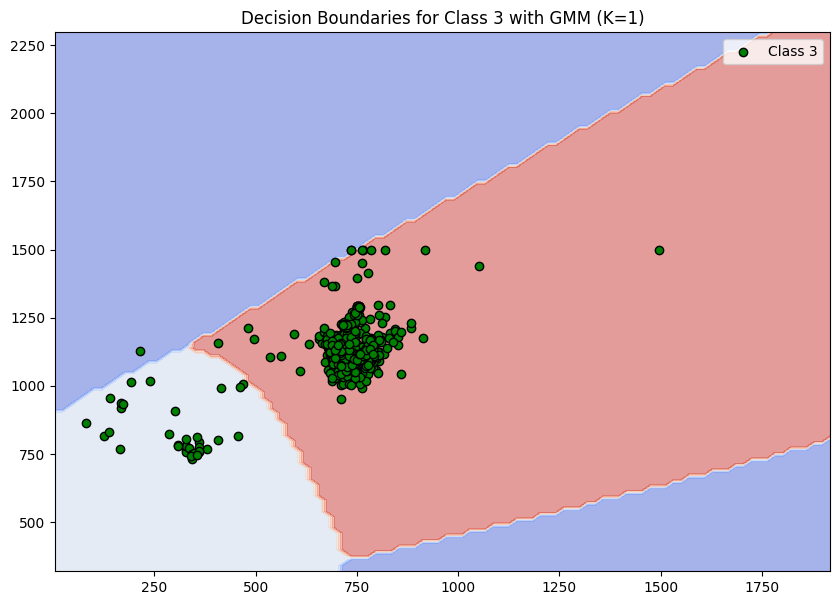


Running experiment for K=2...
Confusion Matrix:
[[682.   6.   0.]
 [  0. 743.   4.]
 [  2.  18. 630.]]
Accuracy: 0.9856
Precision: 0.9865
Recall: 0.9851
F1-Score: 0.9857


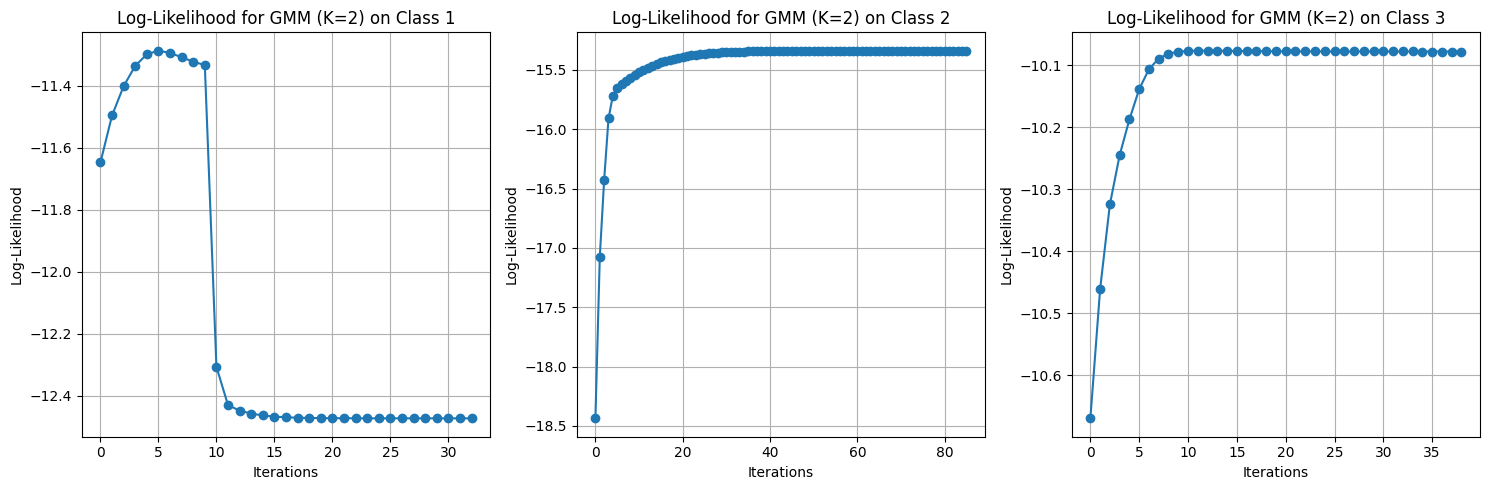

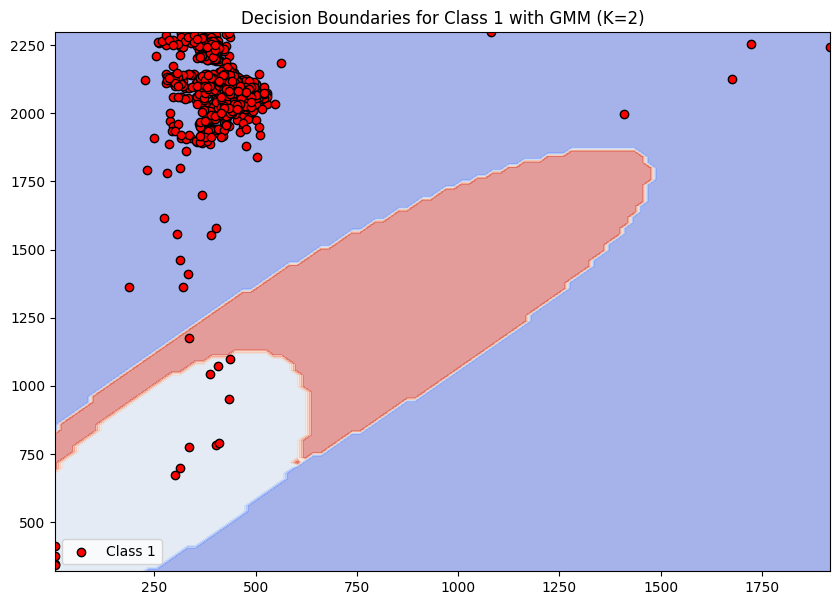

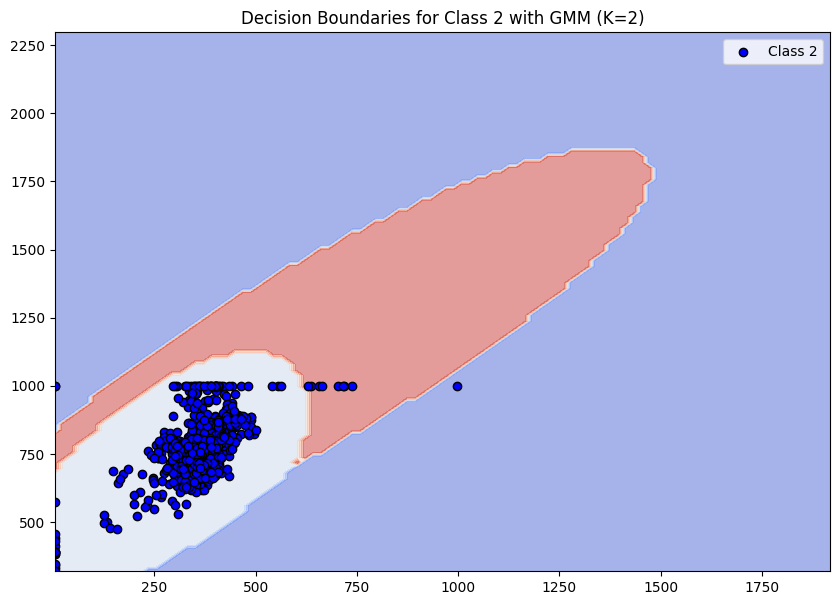

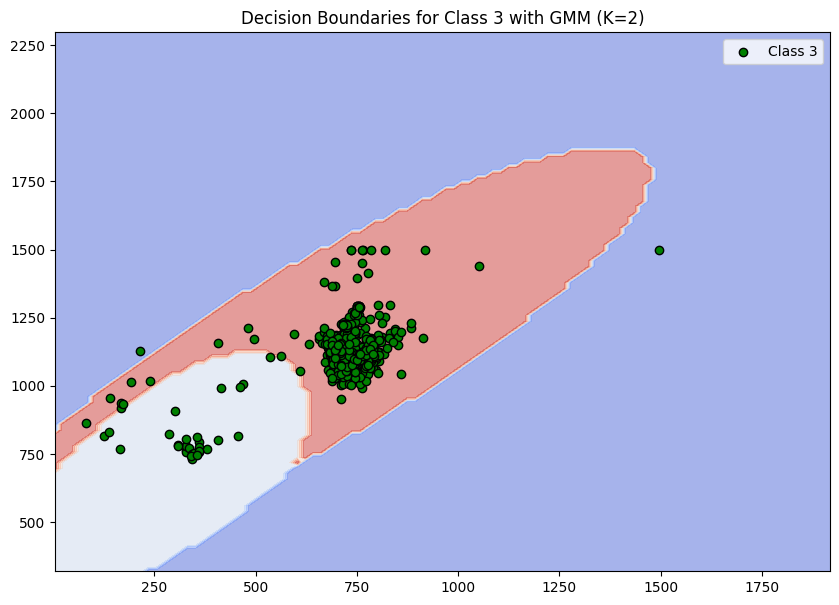


Running experiment for K=8...
Confusion Matrix:
[[681.   5.   2.]
 [  0. 745.   2.]
 [  1.  19. 630.]]
Accuracy: 0.9861
Precision: 0.9870
Recall: 0.9855
F1-Score: 0.9861


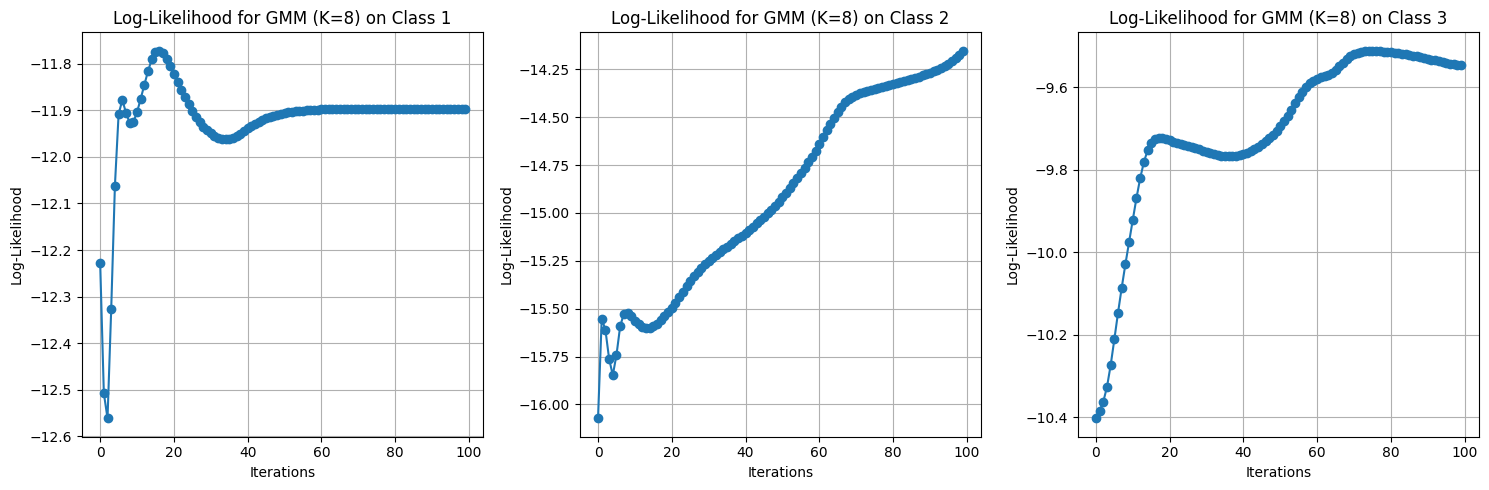

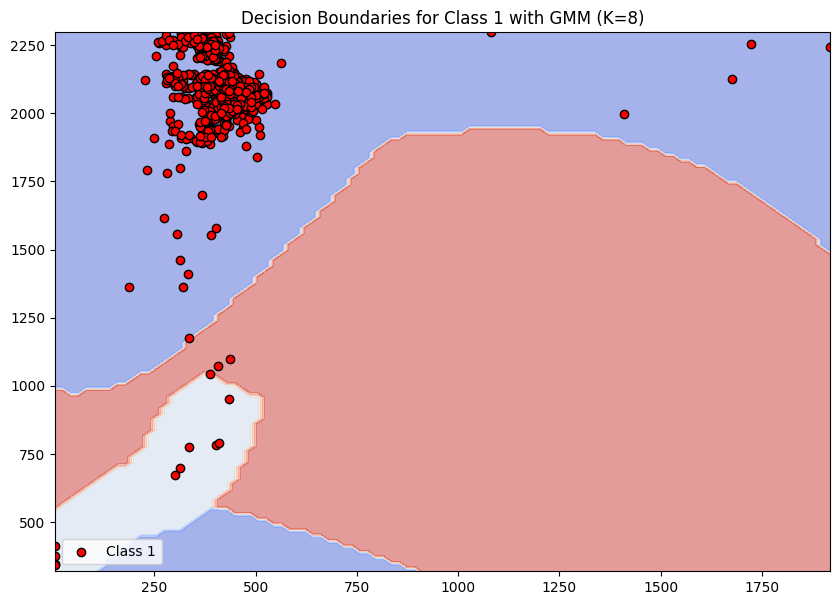

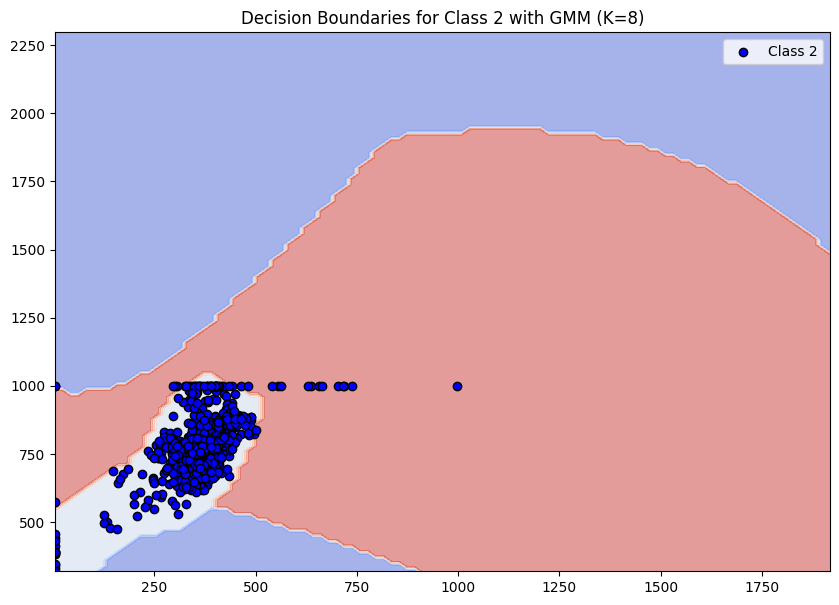

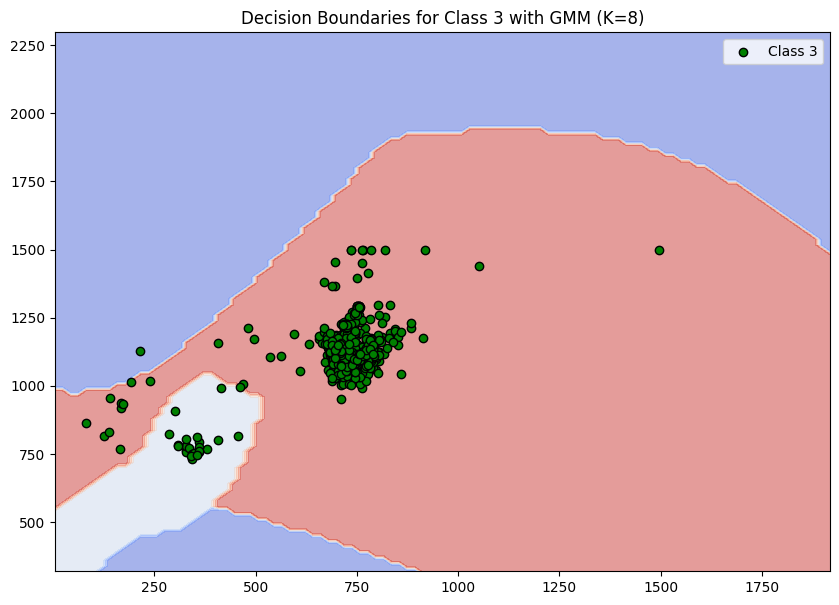


Running experiment for K=32...
Confusion Matrix:
[[682.   5.   1.]
 [  4. 743.   0.]
 [  2.  18. 630.]]
Accuracy: 0.9856
Precision: 0.9866
Recall: 0.9851
F1-Score: 0.9857


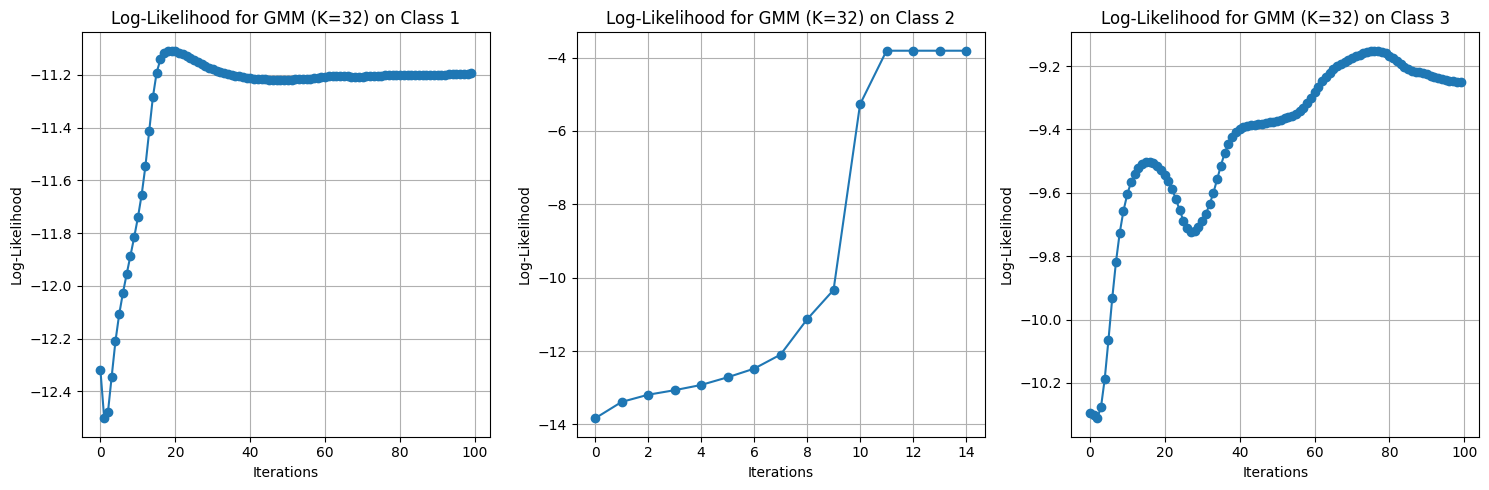

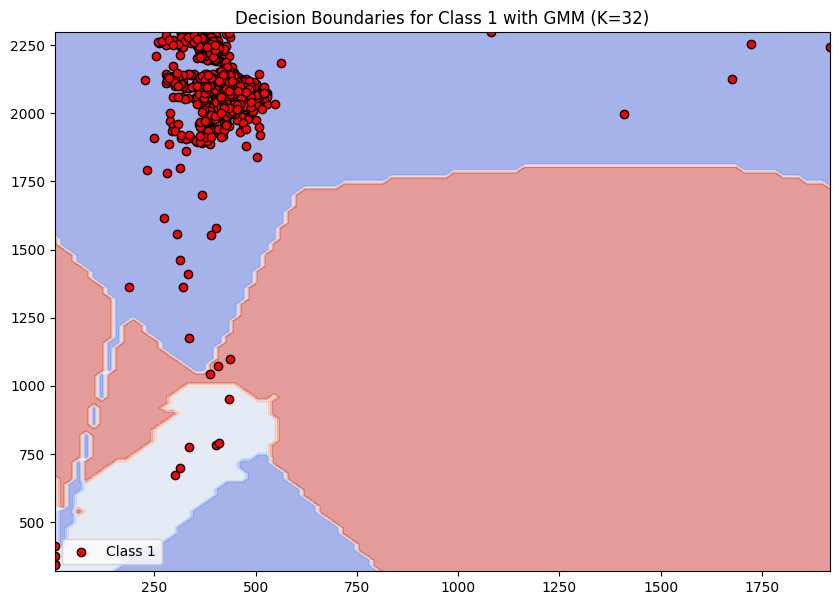

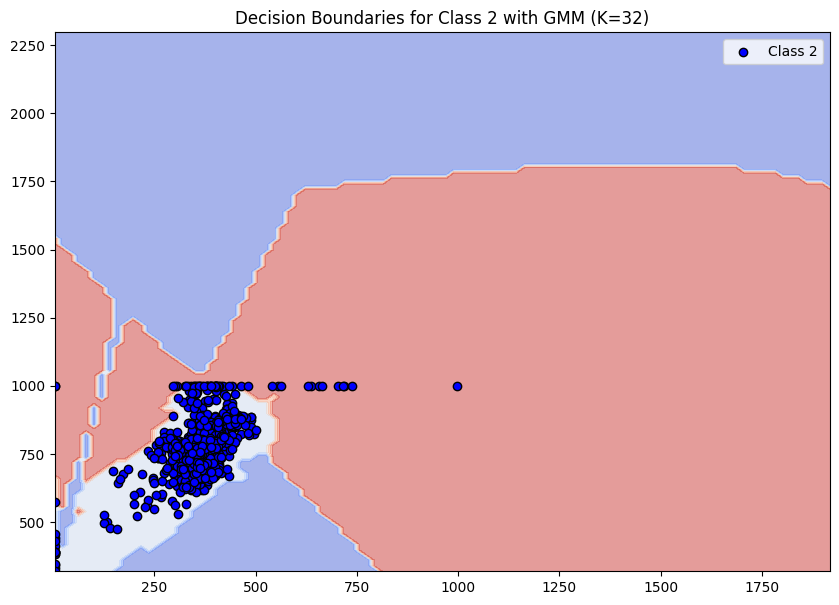

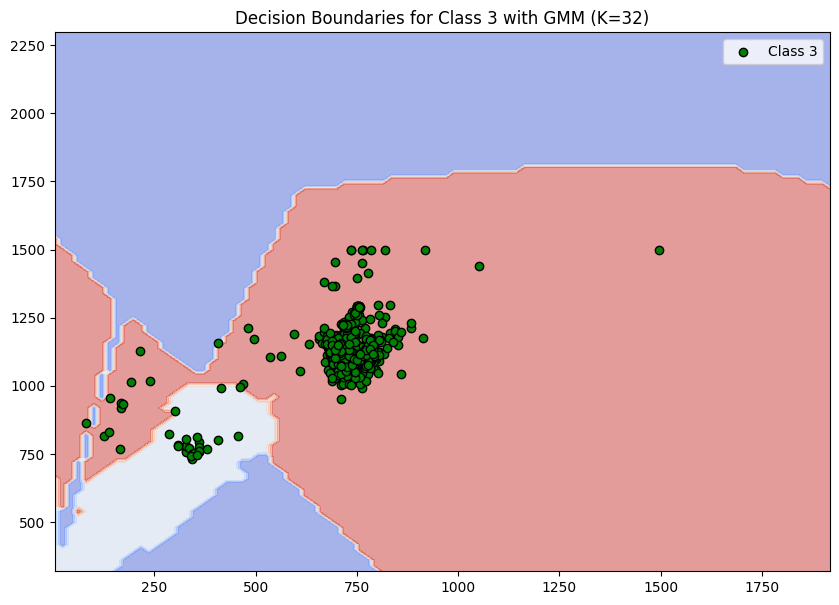

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Gaussian PDF function with regularization
def gaussian_pdf(x, mean, cov, epsilon=1e-6):
    d = len(mean)
    cov += np.eye(d) * epsilon  # Add regularization to the covariance matrix
    x_m = x - mean
    return (1. / (np.sqrt((2 * np.pi)**d * np.linalg.det(cov)))) * \
           np.exp(-0.5 * np.dot(np.dot(x_m.T, np.linalg.inv(cov)), x_m))

# Function to perform GMM with EM algorithm and regularization
def gmm(X, k, max_iters=100, tol=1e-6, epsilon=1e-6, init_means=None, init_covariances=None, init_weights=None):
    n, d = X.shape
    if init_means is None:
        init_means = X[np.random.choice(X.shape[0], k, replace=False)]
    if init_covariances is None:
        init_covariances = np.array([np.cov(X.T) for _ in range(k)])
    if init_weights is None:
        init_weights = np.ones(k) / k
        
    means = init_means
    covariances = init_covariances
    weights = init_weights
    log_likelihoods = []

    for _ in range(max_iters):
        # E-Step: Calculate responsibilities
        responsibilities = np.zeros((n, k))
        for i in range(k):
            for j in range(n):
                responsibilities[j, i] = weights[i] * gaussian_pdf(X[j], means[i], covariances[i], epsilon)
        responsibilities /= responsibilities.sum(axis=1, keepdims=True)

        # M-Step: Update parameters
        N_k = responsibilities.sum(axis=0)
        weights = N_k / n
        means = np.dot(responsibilities.T, X) / N_k[:, np.newaxis]
        covariances = np.array([np.dot((responsibilities[:, i][:, np.newaxis] * (X - means[i])).T, (X - means[i])) / N_k[i]
                                for i in range(k)])

        # Compute log-likelihood
        log_likelihood = np.sum(np.log(np.sum([weights[i] * gaussian_pdf(X[j], means[i], covariances[i], epsilon) 
                                               for i in range(k)], axis=0)))
        log_likelihoods.append(log_likelihood)

        # Check for convergence
        if len(log_likelihoods) > 1 and np.abs(log_likelihoods[-1] - log_likelihoods[-2]) < tol:
            break

    return means, covariances, weights, responsibilities, log_likelihoods

# Bayes Classifier using GMMs
def bayes_classifier_gmm(train_data, test_data, k):
    gmm_params = []
    for class_train in train_data:
        means, covariances, weights, _, _ = gmm(class_train, k)
        gmm_params.append((means, covariances, weights))
    
    predictions = []
    for x in test_data:
        probs = []
        for means, covariances, weights in gmm_params:
            prob = np.sum([weights[i] * gaussian_pdf(x, means[i], covariances[i]) for i in range(k)])
            probs.append(prob)
        predictions.append(np.argmax(probs))
    return np.array(predictions)

# Function to split data into training and test sets (70% training, 30% test)
def train_test_split(class_data_list, test_size=0.3):
    train_data, test_data = [], []
    for class_data in class_data_list:
        n = len(class_data)
        idx = np.random.permutation(n)
        split = int(n * (1 - test_size))
        train_data.append(class_data[idx[:split]])
        test_data.append(class_data[idx[split:]])
    return train_data, test_data

# Function to evaluate performance (Precision, Recall, F1, Confusion Matrix)
def evaluate_performance(y_true, y_pred):
    n_classes = len(np.unique(y_true))
    cm = np.zeros((n_classes, n_classes))
    
    for i in range(len(y_true)):
        cm[int(y_true[i]), int(y_pred[i])] += 1
    
    accuracy = np.trace(cm) / np.sum(cm)
    precision = np.diag(cm) / np.sum(cm, axis=0)
    recall = np.diag(cm) / np.sum(cm, axis=1)
    f1 = 2 * precision * recall / (precision + recall)
    
    print(f"Confusion Matrix:\n{cm}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {np.nanmean(precision):.4f}")
    print(f"Recall: {np.nanmean(recall):.4f}")
    print(f"F1-Score: {np.nanmean(f1):.4f}")
    
    return cm, accuracy, precision, recall, f1


# Function to plot log-likelihoods for each class
def plot_log_likelihoods_for_classes(log_likelihoods_list, titles):
    plt.figure(figsize=(15, 5))
    for i, (log_likelihoods, title) in enumerate(zip(log_likelihoods_list, titles)):
        plt.subplot(1, len(log_likelihoods_list), i + 1)
        plt.plot(log_likelihoods, marker='o')
        plt.title(title)
        plt.xlabel('Iterations')
        plt.ylabel('Log-Likelihood')
        plt.grid(True)
    plt.tight_layout()
    plt.show()

# Function to plot decision boundaries for each class separately
def plot_decision_boundaries_separate(train_data, gmm_params, k, resolution=100):
    # Create a grid of points
    x_min, x_max = np.min(np.vstack(train_data)[:, 0]), np.max(np.vstack(train_data)[:, 0])
    y_min, y_max = np.min(np.vstack(train_data)[:, 1]), np.max(np.vstack(train_data)[:, 1])
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, resolution), np.linspace(y_min, y_max, resolution))

    # Flatten the grid to pass it through the classifier
    grid_points = np.c_[xx.ravel(), yy.ravel()]

    # Classify each point in the grid
    Z = np.zeros(grid_points.shape[0])
    for i, point in enumerate(grid_points):
        probs = []
        for means, covariances, weights in gmm_params:
            prob = np.sum([weights[j] * gaussian_pdf(point, means[j], covariances[j]) for j in range(k)])
            probs.append(prob)
        Z[i] = np.argmax(probs)

    Z = Z.reshape(xx.shape)

    # Plot decision boundaries and the training data points for each class separately
    colors = ['red', 'blue', 'green']
    for idx, class_train in enumerate(train_data):
        plt.figure(figsize=(10, 7))
        plt.contourf(xx, yy, Z, alpha=0.5, cmap=plt.cm.coolwarm)
        plt.scatter(class_train[:, 0], class_train[:, 1], color=colors[idx], label=f'Class {idx + 1}', edgecolor='k')
        plt.title(f'Decision Boundaries for Class {idx + 1} with GMM (K={k})')
        plt.legend()
        plt.show()

# Load the data from the files
def load_data(file_path):
    data = []
    with open(file_path, 'r') as f:
        lines = f.readlines()
        for line in lines:
            data.append(list(map(float, line.strip().split())))
    return np.array(data)


# Main execution (modified to include decision boundary plots)
class1_data = load_data('RD_data/class1.txt')
class2_data = load_data('RD_data/class2.txt')
class3_data = load_data('RD_data/class3.txt')

# Split data into training and test sets (70% training, 30% test)
train_data, test_data = train_test_split([class1_data, class2_data, class3_data])

# Run experiments with different numbers of mixtures for GMM
K_values = [1, 2, 8, 32]
for k in K_values:
    print(f"\nRunning experiment for K={k}...")

    # Prepare test data and labels
    test_samples = np.vstack(test_data)
    y_true = np.concatenate([np.full(len(test_data[i]), i) for i in range(len(test_data))])

    # Run Bayes Classifier using GMM for classification
    y_pred = bayes_classifier_gmm(train_data, test_samples, k)

    # Evaluate performance
    cm, accuracy, precision, recall, f1 = evaluate_performance(y_true, y_pred)

    # Plot log-likelihoods for each class
    log_likelihoods_list = []
    for class_train in train_data:
        _, _, _, _, log_likelihoods = gmm(class_train, k)
        log_likelihoods_list.append(log_likelihoods)
    plot_log_likelihoods_for_classes(log_likelihoods_list, [f'Log-Likelihood for GMM (K={k}) on Class {i + 1}' for i in range(len(train_data))])

    # Train GMMs for each class and store parameters
    gmm_params = []
    for class_train in train_data:
        means, covariances, weights, _, _ = gmm(class_train, k)
        gmm_params.append((means, covariances, weights))

    # Plot decision boundaries separately for each class
    plot_decision_boundaries_separate(train_data, gmm_params, k)



Running experiment for K=64...
Confusion Matrix:
[[684.   4.   0.]
 [  0. 741.   6.]
 [  1.  13. 636.]]
Accuracy: 0.9885
Precision: 0.9889
Recall: 0.9882
F1-Score: 0.9885


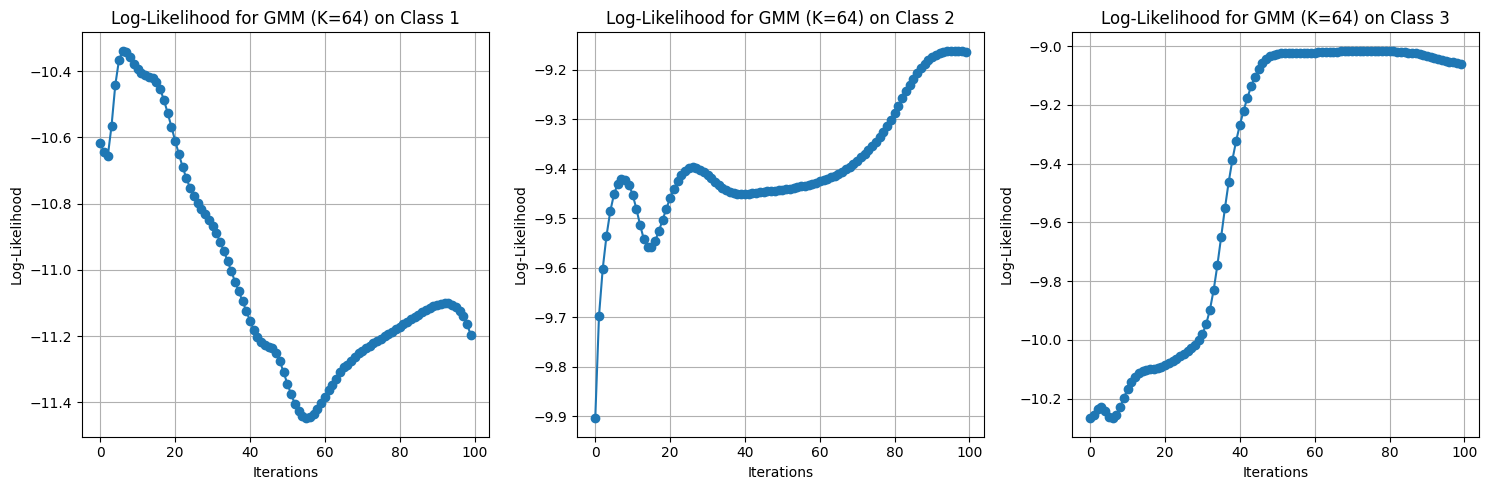

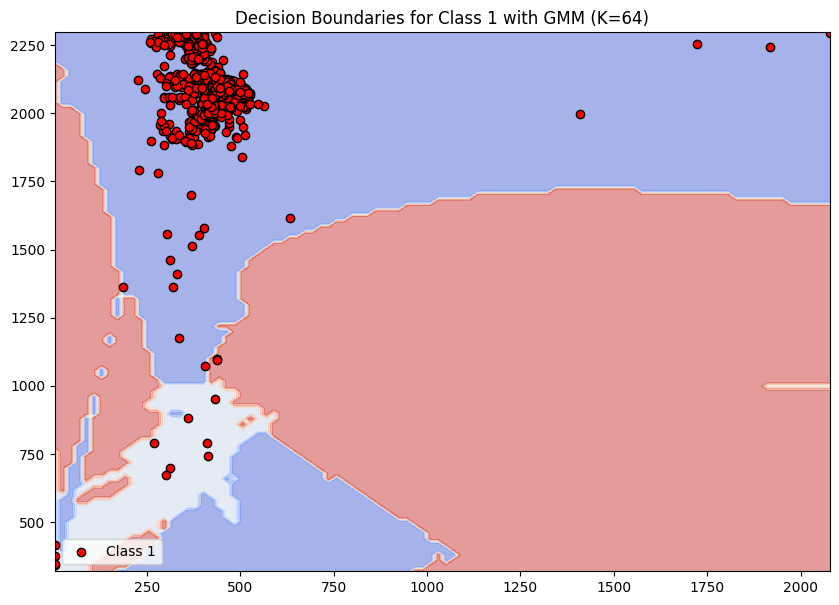

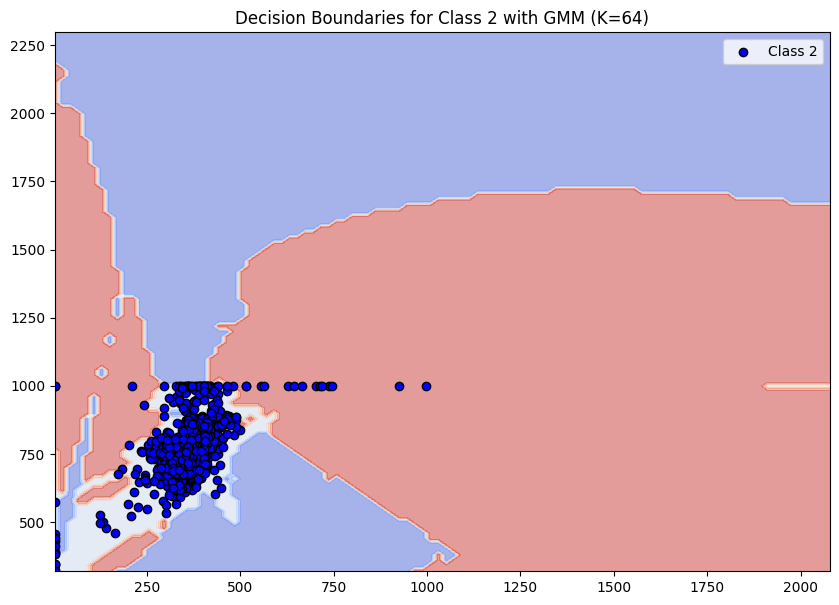

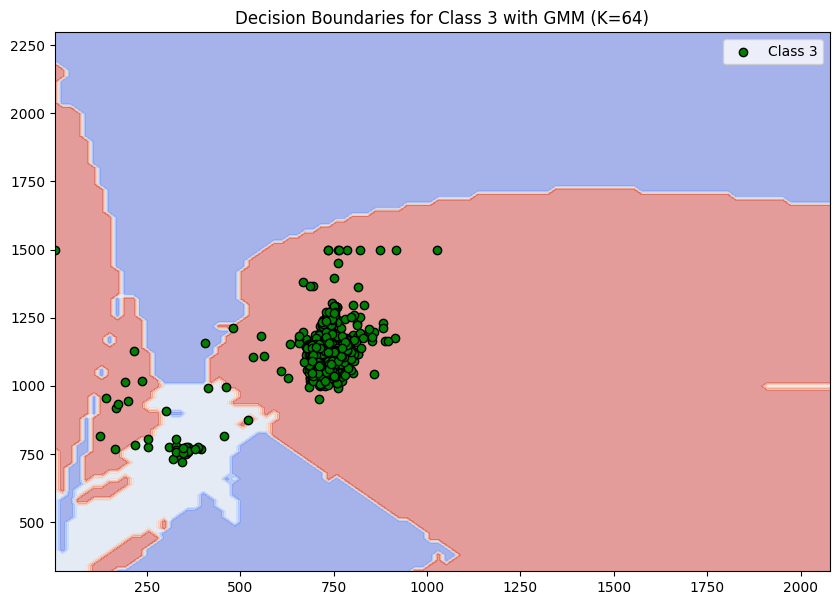

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Gaussian PDF function with regularization
def gaussian_pdf(x, mean, cov, epsilon=1e-6):
    d = len(mean)
    cov += np.eye(d) * epsilon  # Add regularization to the covariance matrix
    x_m = x - mean
    return (1. / (np.sqrt((2 * np.pi)**d * np.linalg.det(cov)))) * \
           np.exp(-0.5 * np.dot(np.dot(x_m.T, np.linalg.inv(cov)), x_m))

# Function to perform GMM with EM algorithm and regularization
def gmm(X, k, max_iters=100, tol=1e-6, epsilon=1e-6, init_means=None, init_covariances=None, init_weights=None):
    n, d = X.shape
    if init_means is None:
        init_means = X[np.random.choice(X.shape[0], k, replace=False)]
    if init_covariances is None:
        init_covariances = np.array([np.cov(X.T) for _ in range(k)])
    if init_weights is None:
        init_weights = np.ones(k) / k
        
    means = init_means
    covariances = init_covariances
    weights = init_weights
    log_likelihoods = []

    for _ in range(max_iters):
        # E-Step: Calculate responsibilities
        responsibilities = np.zeros((n, k))
        for i in range(k):
            for j in range(n):
                responsibilities[j, i] = weights[i] * gaussian_pdf(X[j], means[i], covariances[i], epsilon)
        responsibilities /= responsibilities.sum(axis=1, keepdims=True)

        # M-Step: Update parameters
        N_k = responsibilities.sum(axis=0)
        weights = N_k / n
        means = np.dot(responsibilities.T, X) / N_k[:, np.newaxis]
        covariances = np.array([np.dot((responsibilities[:, i][:, np.newaxis] * (X - means[i])).T, (X - means[i])) / N_k[i]
                                for i in range(k)])

        # Compute log-likelihood
        log_likelihood = np.sum(np.log(np.sum([weights[i] * gaussian_pdf(X[j], means[i], covariances[i], epsilon) 
                                               for i in range(k)], axis=0)))
        log_likelihoods.append(log_likelihood)

        # Check for convergence
        if len(log_likelihoods) > 1 and np.abs(log_likelihoods[-1] - log_likelihoods[-2]) < tol:
            break

    return means, covariances, weights, responsibilities, log_likelihoods

# Bayes Classifier using GMMs
def bayes_classifier_gmm(train_data, test_data, k):
    gmm_params = []
    for class_train in train_data:
        means, covariances, weights, _, _ = gmm(class_train, k)
        gmm_params.append((means, covariances, weights))
    
    predictions = []
    for x in test_data:
        probs = []
        for means, covariances, weights in gmm_params:
            prob = np.sum([weights[i] * gaussian_pdf(x, means[i], covariances[i]) for i in range(k)])
            probs.append(prob)
        predictions.append(np.argmax(probs))
    return np.array(predictions)

# Function to split data into training and test sets (70% training, 30% test)
def train_test_split(class_data_list, test_size=0.3):
    train_data, test_data = [], []
    for class_data in class_data_list:
        n = len(class_data)
        idx = np.random.permutation(n)
        split = int(n * (1 - test_size))
        train_data.append(class_data[idx[:split]])
        test_data.append(class_data[idx[split:]])
    return train_data, test_data

# Function to evaluate performance (Precision, Recall, F1, Confusion Matrix)
def evaluate_performance(y_true, y_pred):
    n_classes = len(np.unique(y_true))
    cm = np.zeros((n_classes, n_classes))
    
    for i in range(len(y_true)):
        cm[int(y_true[i]), int(y_pred[i])] += 1
    
    accuracy = np.trace(cm) / np.sum(cm)
    precision = np.diag(cm) / np.sum(cm, axis=0)
    recall = np.diag(cm) / np.sum(cm, axis=1)
    f1 = 2 * precision * recall / (precision + recall)
    
    print(f"Confusion Matrix:\n{cm}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {np.nanmean(precision):.4f}")
    print(f"Recall: {np.nanmean(recall):.4f}")
    print(f"F1-Score: {np.nanmean(f1):.4f}")
    
    return cm, accuracy, precision, recall, f1


# Function to plot log-likelihoods for each class
def plot_log_likelihoods_for_classes(log_likelihoods_list, titles):
    plt.figure(figsize=(15, 5))
    for i, (log_likelihoods, title) in enumerate(zip(log_likelihoods_list, titles)):
        plt.subplot(1, len(log_likelihoods_list), i + 1)
        plt.plot(log_likelihoods, marker='o')
        plt.title(title)
        plt.xlabel('Iterations')
        plt.ylabel('Log-Likelihood')
        plt.grid(True)
    plt.tight_layout()
    plt.show()

# Function to plot decision boundaries for each class separately
def plot_decision_boundaries_separate(train_data, gmm_params, k, resolution=100):
    # Create a grid of points
    x_min, x_max = np.min(np.vstack(train_data)[:, 0]), np.max(np.vstack(train_data)[:, 0])
    y_min, y_max = np.min(np.vstack(train_data)[:, 1]), np.max(np.vstack(train_data)[:, 1])
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, resolution), np.linspace(y_min, y_max, resolution))

    # Flatten the grid to pass it through the classifier
    grid_points = np.c_[xx.ravel(), yy.ravel()]

    # Classify each point in the grid
    Z = np.zeros(grid_points.shape[0])
    for i, point in enumerate(grid_points):
        probs = []
        for means, covariances, weights in gmm_params:
            prob = np.sum([weights[j] * gaussian_pdf(point, means[j], covariances[j]) for j in range(k)])
            probs.append(prob)
        Z[i] = np.argmax(probs)

    Z = Z.reshape(xx.shape)

    # Plot decision boundaries and the training data points for each class separately
    colors = ['red', 'blue', 'green']
    for idx, class_train in enumerate(train_data):
        plt.figure(figsize=(10, 7))
        plt.contourf(xx, yy, Z, alpha=0.5, cmap=plt.cm.coolwarm)
        plt.scatter(class_train[:, 0], class_train[:, 1], color=colors[idx], label=f'Class {idx + 1}', edgecolor='k')
        plt.title(f'Decision Boundaries for Class {idx + 1} with GMM (K={k})')
        plt.legend()
        plt.show()

# Load the data from the files
def load_data(file_path):
    data = []
    with open(file_path, 'r') as f:
        lines = f.readlines()
        for line in lines:
            data.append(list(map(float, line.strip().split())))
    return np.array(data)


# Main execution (modified to include decision boundary plots)
class1_data = load_data('RD_data/class1.txt')
class2_data = load_data('RD_data/class2.txt')
class3_data = load_data('RD_data/class3.txt')

# Split data into training and test sets (70% training, 30% test)
train_data, test_data = train_test_split([class1_data, class2_data, class3_data])

# Run experiments with different numbers of mixtures for GMM
K_values = [64]
for k in K_values:
    print(f"\nRunning experiment for K={k}...")

    # Prepare test data and labels
    test_samples = np.vstack(test_data)
    y_true = np.concatenate([np.full(len(test_data[i]), i) for i in range(len(test_data))])

    # Run Bayes Classifier using GMM for classification
    y_pred = bayes_classifier_gmm(train_data, test_samples, k)

    # Evaluate performance
    cm, accuracy, precision, recall, f1 = evaluate_performance(y_true, y_pred)

    # Plot log-likelihoods for each class
    log_likelihoods_list = []
    for class_train in train_data:
        _, _, _, _, log_likelihoods = gmm(class_train, k)
        log_likelihoods_list.append(log_likelihoods)
    plot_log_likelihoods_for_classes(log_likelihoods_list, [f'Log-Likelihood for GMM (K={k}) on Class {i + 1}' for i in range(len(train_data))])

    # Train GMMs for each class and store parameters
    gmm_params = []
    for class_train in train_data:
        means, covariances, weights, _, _ = gmm(class_train, k)
        gmm_params.append((means, covariances, weights))

    # Plot decision boundaries separately for each class
    plot_decision_boundaries_separate(train_data, gmm_params, k)


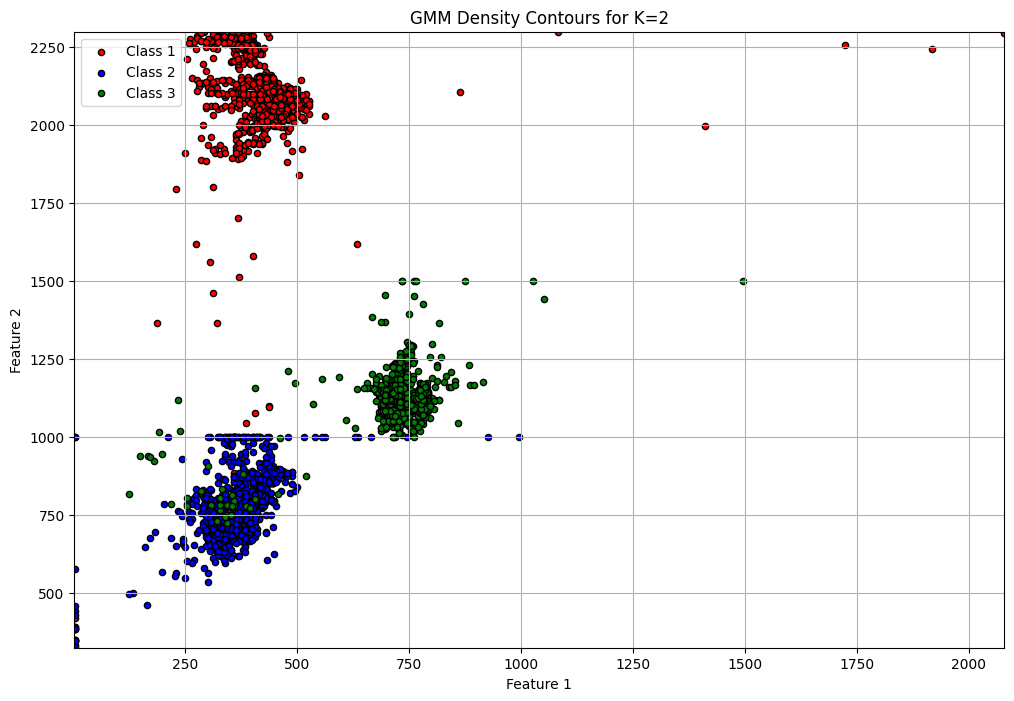

In [8]:
import numpy as np
import matplotlib.pyplot as plt

def plot_gmm_density_contours(train_data, gmm_params, k, resolution=100):
    """
    Plots the constant density contour for all classes with the training data superimposed.
    
    Parameters:
    - train_data: List of training data arrays for each class.
    - gmm_params: List of GMM parameters (means, covariances, weights) for each class.
    - k: Number of GMM components for each class.
    - resolution: Grid resolution for contour plotting.
    """
    # Create a color map for plotting
    colors = ['red', 'blue', 'green', 'purple']
    
    plt.figure(figsize=(12, 8))

    # Plot the density contours for each class
    for class_idx, (class_train_data, (means, covariances, weights)) in enumerate(zip(train_data, gmm_params)):
        # Plot the training data points for the current class
        plt.scatter(class_train_data[:, 0], class_train_data[:, 1], s=20, color=colors[class_idx % len(colors)], label=f'Class {class_idx + 1}', edgecolor='k')

        # Plot the Gaussian contours for each component
        for i in range(k):
            mean = means[i]
            cov = covariances[i]

            # Create a grid of points
            x_min, x_max = class_train_data[:, 0].min() - 1, class_train_data[:, 0].max() + 1
            y_min, y_max = class_train_data[:, 1].min() - 1, class_train_data[:, 1].max() + 1
            xx, yy = np.meshgrid(np.linspace(x_min, x_max, resolution), np.linspace(y_min, y_max, resolution))

            # Calculate the density values for the grid using the Gaussian PDF
            zz = np.array([gaussian_pdf(np.array([x, y]), mean, cov) for x, y in zip(np.ravel(xx), np.ravel(yy))])
            zz = zz.reshape(xx.shape)

            # Plot the contour for the current Gaussian component
            plt.contour(xx, yy, zz, levels=[0.01], colors=colors[class_idx % len(colors)], alpha=0.6)

    plt.title(f'GMM Density Contours for K={k}')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend()
    plt.grid(True)
    plt.show()

# Main execution
# Set the number of components
k = 32

# Train GMMs for each class and store parameters
gmm_params = []
for class_train in train_data:
    means, covariances, weights, _, _ = gmm(class_train, k)
    gmm_params.append((means, covariances, weights))

# Plot GMM density contours with training data for each class
plot_gmm_density_contours(train_data, gmm_params, k)
